# Solving differential equations using neural networks

Neural networks have gathered enormous attention in the last decade. Our whole human community have been shocked with the ability to talk to ChatGPT and create convincing videos of [Taylor Swift proving that $\sqrt{2}$ is irrational](https://www.youtube.com/watch?v=meudJkjKEe8), while also [questioning the ethics behind their training schemes](https://www.reuters.com/legal/litigation/google-sued-by-us-artists-over-ai-image-generator-2024-04-29/), and [their ability to strengthen biases](https://www.nea.org/nea-today/all-news-articles/does-ai-have-bias-problem). 

However, we don't usually discuss the reason why neural networks work at all:  they are universal approximators. This means [they have the capacity to approximate any continuous function, given enough training and the appropriate architecture](https://en.wikipedia.org/wiki/Universal_approximation_theorem). 

For that reason, neural networks can not only reproduce patterns image, voice, and text  but also directly approximate solutions of well-posed mathematical problems. One area in which this is useful is solving differential equations. 

As mathematicians and scientists are aware, besides the small class of [linear ordinary differential equations](https://en.wikipedia.org/wiki/Linear_differential_equation) there is no unified theory on how to solve them. In practice we usually try transform the differential equation in a system of ordinary differential equations using techniques, such as [separation of variables](https://math.libretexts.org/Courses/Monroe_Community_College/MTH_211_Calculus_II/Chapter_8%3A_Introduction_to_Differential_Equations/8.3%3A_Separable_Differential_Equations), or by guesses (in current mathematical terminology [Ansatz](https://en.wikipedia.org/wiki/Ansatz)) from which the solution can be verified. However, there is no guarantees that it can work for an arbitrary differential equation. 

In this post, I will show how to use a neural network to solve differential equations. This framework is usually referred to as [physics-informed neural networks (PINNs)](https://doi.org/10.1016/j.jcp.2018.10.045). As the main example, we will work on a classic differential equation many physics students are familiar with: the damped harmonic oscillator. 

While there are other good texts giving a similar lesson, [often with the same example](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/),  from what I have gathered, they usually assume there is some form of data the neural network is supposed to fit. 

In what follows, we will train a neural network that will *only* solve the mathematics involved in the differential equation.

Before anything else, let us setup the necessary libraries, here we will use [PyTorch](https://pytorch.org/) to implement our neural network.

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(42)

import matplotlib.pyplot as plt
from math import pi

## The damped harmonic oscillator and its differential equation

Suppose I have a system of a spring and a mass allowed to move on a table as in the figure below:

<figure>
  <img src="https://github.com/PessoaP/blog/blob/master/PINN/Spring.png?raw=true" alt="S"/>
</figure>




Say the mass is moved from the spring stable position by a displacement $x_0$ and released. We want to find how the position of the mass,  $x$, evolves in time. 

Two forces act on the mass: the first is the restoring force from the spring, usually modeled through [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law) as $F_\text{spring} = -kx$, with the $-$ sign representing that 
the force is *opposite* to where the spring is pushed from its stable position, conventionally chosen as $x=0$. Here we use the forces as scalar, as we constrain the mass to move within one dimension.

The other force is the friction opposing the movement $F_\text{friction} = -\lambda \frac{\mathrm{d}x}{{\mathrm{d}t}}$. Although we refer to this as a friction force, this is *not* the [friction model usually taught in early courses in physics](http://www.physicsbootcamp.org/forces-Static-Friction.html) but rather more akin to [damping due to movement in a viscous fluid](http://www.physicsbootcamp.org/forces-Drag-Force.html), with $\lambda$ being the *viscous damping coefficient*. One can think on this more like air resistance than friction with the table surface. 

Using Newton's second law of motion, the total force, $F$, is equal to  mass times acceleration $m \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}}$, allowing us to write the differential equation as 
$$ m \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}} = -kx -\lambda \frac{\mathrm{d}x}{{\mathrm{d}t}} \ . \ \ \ (1) $$
with some algebraic steps we can rewrite the equation above as 
$$ \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}} + \xi \frac{\mathrm{d}x}{{\mathrm{d}t}}  + \omega_0^2 x = 0 \ , \ \ \ (2) $$
with $\omega_0 = \sqrt{k/m}$ and $\xi =\lambda/m$. 


Say I push the spring and release it. Defining $t=0$ as the time at which the mass is released, $x_0$ the position at that time, and knowing that it was released from rest we can write
$$ x(0) = x_0 , \ \ \text{and} \ \ \frac{\mathrm{d}x}{{\mathrm{d}t}} \Bigr|_{t=0} = 0 \ . \ \ \ (3) $$
In the language of differential equations we say this is our *initial condition*. We say we solve the differential equation if we find $x(t)$, or the position of the mass as a function of time, that obeys both (2) and (3).

## Solving the 'underdamped' case

First let us assume a case where $\xi < 2\omega_0$. In rough terms, that means that the damping is weaker than the overall spring force. In other words, the system is underdamped. The next block of code will set what the variables of the problem: $x_0, \omega_0, \text{and}, \xi$

In [2]:
x0 = 1.
w0 = 4*pi
xi = 2

### Exact solution
In order to have something to compare our solution to, let us see if there are standard ways to solve (2) in the the underdamped condition. It has been proven (see *e.g* [here](http://www.physicsbootcamp.org/Damped-Harmonic-Oscillator.html), but it can be found in virtually any physics I textbook) that the exact solution is given by:
$$x(t) = x_0 e^{-\frac{\xi}{2} t } \cos(\omega t)  \ ,$$
where $\omega = \sqrt{\omega_0^2 - \xi^2/4}$. Note that the condition for the underdamped case, $\xi<2\omega_0$, is also the condition for $\omega$ to be real-valued (the quantity under the square root is positive).

In [3]:
w = torch.sqrt(torch.tensor(w0**2-xi**2/4 ))
x_sol_under= lambda t: x0*torch.exp(-.5*xi*t)*torch.cos(w*t)

An attentive reader may notice through direct differentiating $x$ above that it, indeed, solves (2) and obeys (3). In the process they will notice how labourious it is to verify that ansatz, let alone come up with them. However we can intuit on its meaning. The solution is an oscillation, represented by the $\cos(\omega t)$ factor, and the oscillating amplitude decays exponentially as $x_0 e^{-\xi/2 t }$. This can be directly seen in the graph below

Text(0, 0.5, 'Position')

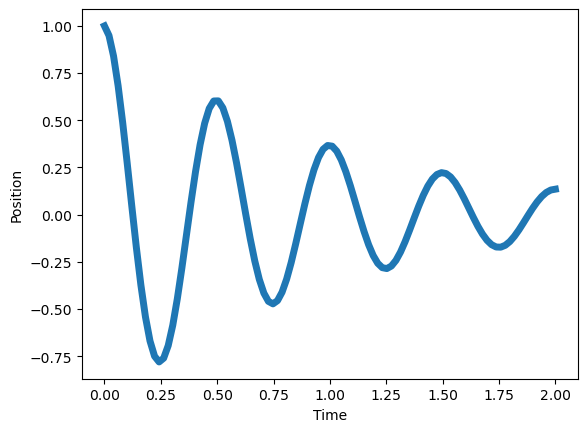

In [4]:
t = torch.linspace(0, 2, 100)[:, None]

plt.plot(t.numpy(),x_sol_under(t),linewidth=5)
plt.xlabel('Time')
plt.ylabel('Position')

### Solving with neural network

If we want to solve the problem with neural networks, we need to start by defining our neural architecture. The goal is to use the neural network to creat a single-value function of time, $t$, which we refer to as $\mathcal{N}(t)$ and use it to generate $x(t)$. Thus our architecture needs to map a single feature into (another) single feature but still have the necessary complexity to fit a complicated function.  For this post we will use a sequential model composed of four [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers. The architecture maps from 1 to 64 features, then from 64 to 256 features, followed by 256 to 64 features, and finally from 64 to 1 feature, with [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activation.

In [5]:
architecture = lambda: nn.Sequential(nn.Linear(1, 64), nn.GELU(),
                                     nn.Linear(64, 256), nn.GELU(),
                                     nn.Linear(256, 64), nn.GELU(),
                                     nn.Linear(64,1, bias=False))

N = architecture()

Now, as it is often the case with neural networks, it may be challenging to interpret what the neural network internal parameters do to solve the problem as a whole. Besides the architecture selection we have little control over what $\mathcal{N}(t)$ is initially. The goal, then, becomes to train the neural network to solve our differential equation (2) while obeying the initial condition (3). 

In order to do so, it is useful to define the following function
$$ \tilde{x}(t) \equiv x_0 + \mathcal{N}(t)  t^2 \ , \ \ \ (4) $$
with the symbol $\equiv$ meaning ''defined as equal to''.

In [6]:
x_t = lambda t,N: x0+N(t)*(t**2)

Note that *by definition* we have $\tilde{x}(0)=x_0$ and $\frac{\mathrm{d}x}{{\mathrm{d}t}}\Bigr|_{t=0} = 0$ obeying the initial condition (3) no matter what the network is. The goal, then, is to train the neural network (change $\mathcal{N}$) so that  $ \tilde{x}(t)$ approximates the solution of the differential equation (2).

So, in order to train the neural network we ought to define a loss function to later be minimized. If $\tilde{x}(t)$ is to approximate the solution of (2) we must have 
$$ \frac{\mathrm{d}^2 \tilde{x} }{{\mathrm{d}t^2}} + \xi \frac{\mathrm{d}\tilde{x} }{{\mathrm{d}t}}  + \omega_0^2 \tilde{x} \approx 0 \ . \ \ \ (5) $$
at every time $t$. 

While it is hard to guarantee that the approximation above holds across a continuous interval, let us create an array of "test" times `t` of 500 points from $t=0$ to $t=2$.

In [7]:
t = torch.linspace(0, 2, 500).reshape(-1,1)

Thus, within the interval $t \in [0,2]$ we replace the approximation (5), taken for continuous time $t$, by the saying that at each element $t_k$ in the array `t` we must have
$$   \frac{\mathrm{d}^2 \tilde{x}  }{{\mathrm{d}t^2}} \Bigr|_{t=t_k}+ \xi \frac{\mathrm{d}\tilde{x}}{{\mathrm{d}t}}\Bigr|_{t=t_k} + \omega_0^2 \tilde{x}(t_k) \approx 0\ .  $$


For that, let us define the *loss function* $\mathcal{L}$ as 
$$ \mathcal{L}(\mathcal{N})  \equiv \frac{1}{K}  \sum_{k=0}^K  \left[ \frac{\mathrm{d}^2 \tilde{x}  }{{\mathrm{d}t^2}} \Bigr|_{t=t_k}+ \xi \frac{\mathrm{d}\tilde{x}}{{\mathrm{d}t}}\Bigr|_{t=t_k} + \omega_0^2 \tilde{x} (t_k) \right]^2 \ . \ \ \ (6) $$
Note that $\mathcal{L}$ is *strictly* non-negative (it is a sum of squared terms), therefore its minumum possible value is 0, which would be equivalent $\tilde{x}$ obeying (3) at every test point $t_k$ in `t`.

It may look challenging to calculate the derivatives of $\tilde{x}$ inside $\mathcal{L}$, however this can be done straightforwardly, since neural network libraries [usually contain tools to automatically calculate derivatives of a function](https://labpresse.com/what-is-autograd-automatic-differentiation-and-optimization-with-pytorch/). Here we use PyTorch's `autograd` tool

In [8]:
def loss(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi*dxdt +(w**2)*x
    return torch.mean(torch.pow(loss_ode,2))

We, then, train the network, meaning change the internal parameters within the network, in other words changing $\mathcal{N}$, so that $\mathcal{L}(\mathcal{N})$ takes smaller values, and say we are done training when the loss function is smaller than some threshold value (we use .1). This is done by the following block of code.

In [9]:
optimizer = torch.optim.Adam(N.parameters())

l = loss(t,N)
i=0

while l.item()>.1:
    optimizer.zero_grad()
    l = loss(t,N)
    l.backward()
    optimizer.step()

    ## Took around 1.5 mins in my machine

While it is not our goal to fully describe the training of neural networks, it is relevant to think more abstractly on what the previous block of code does. It identifies function $\mathcal{N}$, among the ones that can be generated by the architecture, that minimizes $\mathcal{L}$, and the $\tilde{x}(t)$ generated from $\mathcal{N}$ by (4) is the approximation of the differential equation's solution. As such, let us visualize how well does our neural network solution compare to the known exact solution.

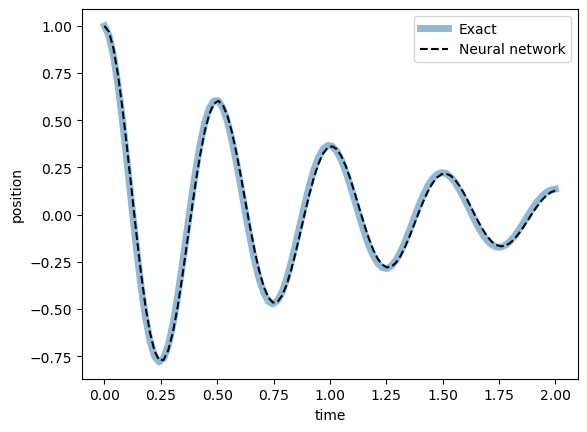

In [10]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N).numpy() #Neural
xt = x_sol_under(tt) #Exact

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


Now, as good as the result may look, so far we have only dealt with the underdamped case $\xi < 2\omega_0$. But neural network training idea presented here can, indeed, be extended generally, as we will observe below.

## Solving the 'critically damped' case

So far we worked on a case where $\xi < 2\omega_0$. Let us observe how the solution changes, qualitatively,  in the specific case where $\xi = 2\omega_0$ by directly solving this case using the neural network. First, let us define the parameters

In [11]:
w0_critical = 4*pi
xi_critical = w0_critical*2

and, initialize a new network `N_critical` and define a loss function with the new parameters.

In [12]:
N_critical = architecture()

def loss_critical(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi_critical*dxdt +(w0_critical**2)*x
    return torch.mean(torch.pow(loss_ode,2))

We, then, repeat the training loop for this new network

In [13]:
optimizer_critical = torch.optim.Adam(N_critical.parameters())

l = loss_critical(t,N_critical)
i=0

while l.item()>.1:
    optimizer_critical.zero_grad()
    l = loss_critical(t,N_critical)
    l.backward()
    optimizer_critical.step()

and, once again, plot the result

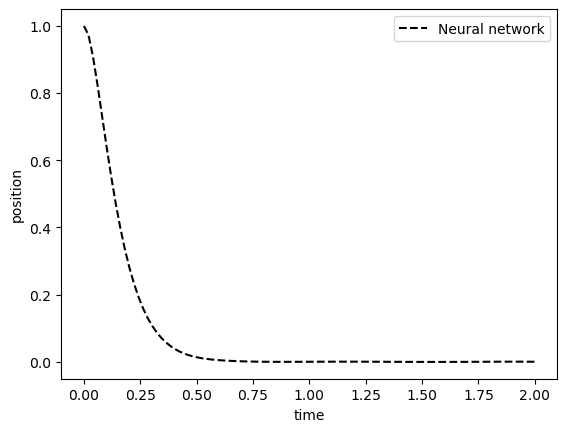

In [14]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_critical).numpy() #Neural
#xt = x_sol(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
#ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


Note that, so far, we have *not* written the exact solution in this critically damped case, as it is *not* part of the neural network training at all. However, to test that neural network arrived at the correct solution, we write the exact solution, which is derived *e.g.* [here](http://www.physicsbootcamp.org/Damped-Harmonic-Oscillator.html) which is given by
$$x(t) = x_0 e^{-\frac{\xi}{2} t }   (1+\omega_0 t) \ .$$


In [15]:
x_sol_critical = lambda t:  x0*torch.exp(-.5*xi_critical*t)*(1+w0_critical*t)

Let us observe how the results compare to the exact solution

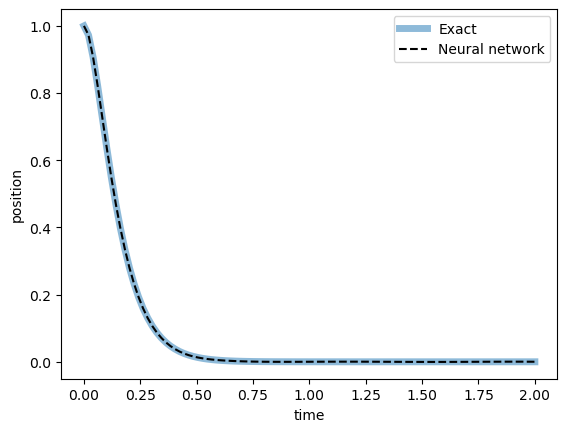

In [16]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_critical).numpy() #Neural
xt = x_sol_critical(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


As with the underdamped case, in this critical case we also observe a near indistinguishable graph between the exact solution and the solution found by the neural network. Now, let us move forward into solve the equation in the overdamped case.

## Solving the 'overdamped' case

Now let us move to the overdamped case, $\xi > 2\omega_0$,  by repeating the neural network procedure. 

In [17]:
w0_over = 4*pi
xi_over = w0_over*4

and procede to define a new network an train it to solve the equation with new parameters

In [18]:
N_over = architecture()

def loss_over(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi_over*dxdt +(w0_over**2)*x
    return torch.mean(torch.pow(loss_ode,2))

optimizer_over = torch.optim.Adam(N_over.parameters())

l = loss_over(t,N_over)
i=0

while l.item()>.1:
    optimizer_over.zero_grad()
    l = loss_over(t,N_over)
    l.backward()
    optimizer_over.step()

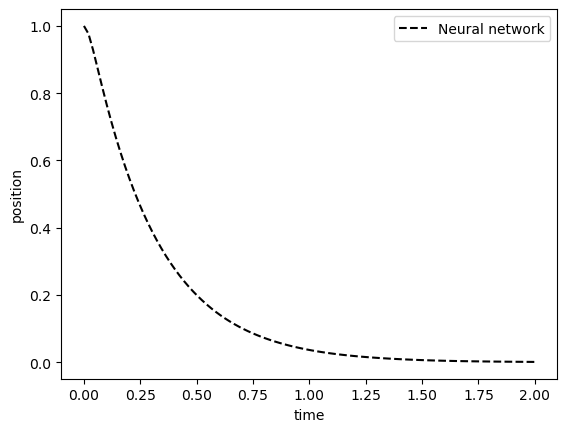

In [19]:
tt = torch.linspace(0, 2, 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_over).numpy() #Neural
#xt = x_sol(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xx, '--', label='Neural network',color='k')

ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


Now, as done in the previous case, let us compare to the exact solution found  [here](http://www.physicsbootcamp.org/Damped-Harmonic-Oscillator.html) to be given as:
$$ x(t) = x_0 e^{-\frac{\xi}{2} t } \left[ C_1 e^{\omega t} + C_2 e^{-\omega t} \right] \ ,  $$
where $\omega = \sqrt{ \xi^2/4  - \omega_0^2 }$, $C_1 = \frac{1}{2} \left( 1 + \frac{\xi}{2\omega} \right)$, and $C_2 = \frac{1}{2} \left( 1 - \frac{\xi}{2\omega} \right)$. Note that the quantity under the square root in $\omega$ is the negative of the equivalent quantity found for the underdamped case, and it is always positive in the overdamped case $\xi > 2\omega_0$.

In [20]:
w_over = torch.sqrt(torch.tensor(xi_over**2/4 - w0_over**2))
c1,c2 = (1+xi_over/(2*w_over))/2, (1-xi_over/(2*w_over))/2
x_sol_over = lambda t:  x0*torch.exp(-.5*xi_over*t)*(c1*torch.exp(w_over*t)+c2*torch.exp(-w_over*t))

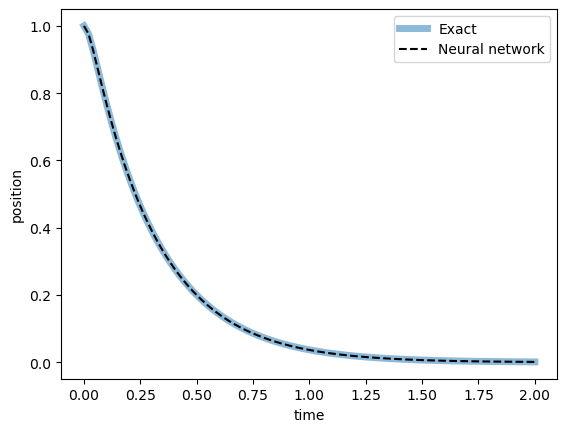

In [21]:
tt = torch.linspace(0, 2, 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_over).numpy() #Neural
xt = x_sol_over(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


## Some comments on the results

While this is meant as an example of solving differential equations with neural networks rather then comments on the physics, It is a good closure to discuss the meaning of our results. We have separated our solutions in 3 schemes: underdamped, critically damped and overdamped. Let us plot the solutions found in each case.

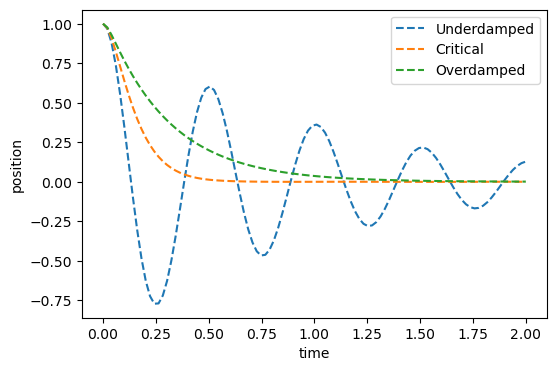

In [22]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx_under = x_t(torch.Tensor(tt),N).numpy() 
    xx_crit = x_t(torch.Tensor(tt),N_critical).numpy()
    xx_over =  x_t(torch.Tensor(tt),N_over).numpy()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tt, xx_under, '--', label='Underdamped')
ax.plot(tt, xx_crit, '--', label='Critical')
ax.plot(tt, xx_over, '--', label='Overdamped')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


In the *underdamped case*, the system exhibits oscillations with gradually decreasing amplitude. This occurs when the damping is insufficient to prevent oscillations, but still present enough to reduce the amplitude over time.

In the *critically damped case*, the system returns to equilibrium as quickly as possible without oscillating. This represents a unique balance where the damping is just enough to prevent oscillations and allows the system to settle into equilibrium in the shortest time.

In the *overdamped case*, the system also does not oscillate but returns to equilibrium more slowly than in the critically damped case. The damping is so strong that it significantly slows down the system's response.


## When the neural network does not work

Notice that when solving the differential equation, we only evaluated the loss function within the interval $t \in [0,2]$. In other words, when training the network, we *only* enforced that the neural network solves the differential equation rithin that interval. We have no guarantee that the function $\tilde{x}$ given by the neural network will obey the differential equation outside of that interval. In fact, let us  directly observe what happens when we try to plot the neural network solution for the underdamped case in the interval $[0,3]$.

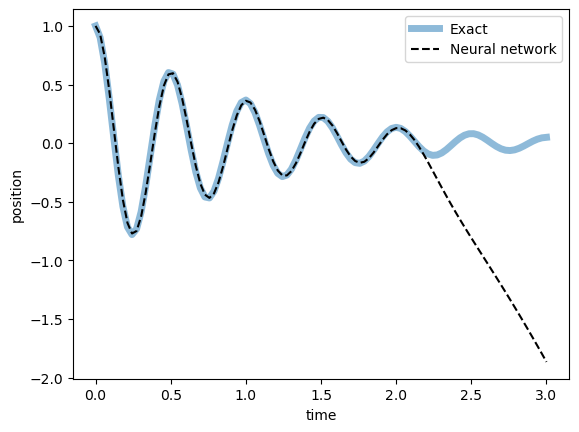

In [23]:
tt = torch.linspace(0, 3., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N).numpy() 
xt = x_sol_under(tt) 


fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()


Thus, we finish this post by warning that using a neural network outside of its training interval can lead to unpredictable and unreliable results. The network may produce outputs that do not conform to the expected behavior of the system it was trained to model. This is because the neural network has not learned the patterns or relationships in the data outside the training interval, and it may extrapolate in ways that are not physically or mathematically accurate.

Nevertheless, the approach to solve differential equations presented here does not make any assumptions on the equation form. By incorporating a loss function that directly checks if the differential equation is solved, one can handle complex and diverse differential equations with minimal assumptions. This flexibility allows them to address a wide range of problems across various scientific and engineering fields, making them a powerful tool for virtually any context.

## Further reading 
- [The original paper that introduced the idea of solving differential equations with neural networks](https://arxiv.org/pdf/physics/9705023)
- [A (relatively) recent review on physics informed neural networks (PINNs)](https://doi.org/10.1016/j.jcp.2018.10.045)
- [Another more lengthy coding tutorial on PINNS](https://nanohub.org/resources/handsonpinns)